In [1]:
from colabtools import adhoc_import
import numpy as np
import matplotlib.pyplot as plt

with adhoc_import.Google3Head():  # comment out if above block is uncommented
  from init2winit.colab import data_loader
  from init2winit.colab import df_utils
  from init2winit.algoperf.workloads import targets
  from init2winit.projects.optlrschedule.notebook_utils import plot_style


In [2]:
# Stylesheet

plot_style.set_style()

In [3]:
# #@title Set matplotlib rc params
# # Define the rcParams dictionary
# rc_params = {
#     # --- FIGURE SIZE & RESOLUTION ---
#     'figure.figsize': (10, 6),   # 10 inches wide, 6 inches tall
#     'figure.dpi': 100,           # Good screen resolution
#     'savefig.dpi': 300,          # High resolution for saving

#     # --- FONT & TEXT ---
#     'font.size': 12,
#     'axes.labelsize': 12,
#     'axes.titlesize': 14,
#     'legend.fontsize': 10,
#     'xtick.labelsize': 10,
#     'ytick.labelsize': 10,

#     # --- STYLE & LINES ---
#     'lines.linewidth': 2.0,
#     'lines.markersize': 2.0,
#     'axes.grid': True,           # Enable grid
#     'grid.alpha': 0.5            # Make grid subtle
# }

# # Apply the parameters
# plt.rcParams.update(rc_params)

In [4]:
#@title Helper functions

# Workload properties
def get_workload_name(experiment):
  workoad_tag = list(filter(lambda x: x.startswith('workload'), experiment['tags']))
  workload_name = workoad_tag[0].split('.')[1]
  return workload_name

def get_target_metric_name(workload_name):
  return targets.validation_targets[workload_name]['metric']

def get_target_metric_value(workload_name):
  return targets.validation_targets[workload_name]['target']

# Experiment DF
def get_hparams(df):
  f = lambda x: x.startswith('hps.opt_hparams') or x.startswith('hps.lr_hparams')
  hparams = list(filter(f, df.columns))
  return hparams

# Load Experimental data into ExperimentInfo and experiment DataFrame

In [5]:
#@title Load experiment
xid = 199786811
experiments = data_loader.get_xm_experiment_info([xid]) # returns dict(xid, ExperimentInfo)

# Uncomment the following lines if you want to see what is in ExperimentInfo
# import pprint
# pprint.pprint(experiments[xid])

In [6]:
#@title Load workload properties
workload_name = get_workload_name(experiments[xid])
metric_name = get_target_metric_name(workload_name)
metric_value = get_target_metric_value(workload_name)

print(f'Workload name: {workload_name}')
print(f'Metric name: {metric_name}')
print(f'Metric value: {metric_value}')

Workload name: imagenet_resnet50
Metric name: valid/error_rate
Metric value: 0.22569


In [7]:
#@title Load trials into an experiment DataFrame
experiment_df, _ = data_loader.parallel_load_trials_from_experiment(experiments[xid], 50) # takes in a ExperimentInfo

experiment_df.head()


,dataset,model,initializer,init_scalars,hparams,model_shape,trial_dir,trial_name,status,hps.activation_function,hps.batch_norm_epsilon,hps.batch_norm_momentum,hps.batch_size,hps.bn_output_scale,hps.data_format,hps.dropout_rate,hps.grad_clip,hps.l2_decay_factor,hps.l2_decay_rank_threshold,hps.label_smoothing,hps.lr_hparams.base_lr,hps.lr_hparams.schedule,hps.lr_hparams.warmup_steps_fraction,hps.model_dtype,hps.num_filters,hps.num_layers,hps.opt_hparams.momentum,hps.opt_hparams.c_mom,hps.opt_hparams.kappa,hps.opt_hparams.weight_decay,hps.optimizer,hps.rng_seed,hps.total_accumulated_batch_size,hps.use_shallue_label_smoothing,hps.virtual_batch_size,hps.crop,hps.input_shape,hps.mixup.alpha,hps.output_shape,hps.randaug.magnitude,hps.randaug.num_layers,hps.random_flip,hps.test_size,hps.train_size,hps.use_grain,hps.use_imagenetv2_test,hps.use_mixup,hps.use_randaug,hps.valid_size,hps.num_device_prefetches,hps.num_tf_data_map_parallel_calls,hps.num_tf_data_prefetches,cost_value,epoch,eval_time,global_step,grad_norm,overall_steps_per_sec,preemption_count,run_time,run_time_no_eval,steps_per_sec,steps_per_sec_no_eval,test/ce_loss,test/error_rate,test/num_examples,train/ce_loss,train/error_rate,train/num_examples,train_cost,update_norm,valid/ce_loss,valid/error_rate,valid/num_examples,study_dir
xGQk8wIVhILOj30u96y+mw,imagenet,mlperf_resnet,noop,None,"{'activation_function': 'relu', 'batch_norm_ep...",None,/cns/cf-d/home/init2winit/rs=6.3/thetish/image...,1,done,relu,0.00001,0.9,1024,0.0,NHWC,0.1,None,None,2,0.1,0.1,cosine_warmup,0.05,float32,64,50,0.9,0.25,0.25,0.000005,momentum,-1,None,False,64,random,"[224, 224, 3]",0.5,[1000],15,2,True,10000,1281167,False,True,False,False,50000,0,-1,-1,"[5.809431076049805, 4.530616760253906, 3.83202...","[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[22.74628186225891, 9.744832515716553, 8.73809...","[1866, 3732, 5598, 7464, 9330, 11196, 13062, 1...","[1.4530525207519531, 1.0185132026672363, 0.677...","[2.228782732263632, 2.2362265951836484, 2.2396...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[836.2694146633148, 804.6312284469604, 809.480...","[813.0903017520905, 794.6714432239532, 770.369...","[2.2313383310224952, 2.319074793556813, 2.3051...","[2.2949480469500663, 2.3481402482889098, 2.422...","[5.56275, 4.143752098083496, 3.344085931777954...","[0.946, 0.8019999861717224, 0.6840000152587891...","[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...","[5.2260823, 3.4849660396575928, 2.512930154800...","[0.9152629, 0.7109375, 0.543701171875, 0.45916...","[49152.0, 49152.0, 49152.0, 49152.0, 49152.0, ...","[6.352313, 5.105607, 4.1407075, 3.6098423, 3.3...","[0.0532026179134845, 0.0974322631955146, 0.118...","[5.294724, 3.59790587425232, 2.701732397079468...","[0.92238, 0.7346400022506714, 0.58465999364852...","[50000.0, 50000.0, 50000.0, 50000.0, 50000.0, ...",/cns/cf-d/home/init2winit/rs=6.3/thetish/image...
HW6dtPDV2ygcjcB95+5+Xw,imagenet,mlperf_resnet,noop,None,"{'activation_function': 'relu', 'batch_norm_ep...",None,/cns/cf-d/home/init2winit/rs=6.3/thetish/image...,2,done,relu,0.00001,0.9,1024,0.0,NHWC,0.1,None,None,2,0.1,0.1,cosine_warmup,0.05,float32,64,50,0.9,0.25,0.50,0.000005,momentum,-1,None,False,64,random,"[224, 224, 3]",0.5,[1000],15,2,True,10000,1281167,False,True,False,False,50000,0,-1,-1,"[6.24615478515625, 5.597581386566162, 4.898159...","[1, 2, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, 19,...","[18.001845598220825, 14.635837078094482, 14.50...","[1866, 3732, 5598, 7464, 9330, 11196, 13062, 1...","[0.7400771975517273, 1.1925277709960938, 1.535...","[2.225662067089696, 2.247578915298285, 2.22239...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[837.4967381954193, 793.7464339733124, 838.644...","[819.2629904747009, 777.8933553695679, 790.158...","[2.2280683791327105, 2.3508767033563003, 2.225...","[2.2776568961314783, 2.3987863980577204, 2.361...","[6.210549, 5.458289623260498, 4.59193563461303...","[0.9733, 0.9350000023841858, 0.853399991989135...","[10000.0, 10000.0, 1000

## Plot eval measurements

In [24]:
#@title Training Curves

# These things are measured and logged at every eval
# It is possible your training algorithm logs more measurements.
measurements = ['epoch',
                'eval_time',
                'global_step',
                'grad_norm',
                'learning_rate',
                'overall_steps_per_sec',
                'preemption_count',
                'run_time',
                'run_time_no_eval',
                'steps_per_sec',
                'steps_per_sec_no_eval',
                'train/ce_loss',
                'train/error_rate',
                'train/num_examples',
                'train/perplexity',
                'train_cost',
                'update_norm',
                'valid/ce_loss',
                'valid/error_rate',
                'valid/num_examples',
                'valid/perplexity']

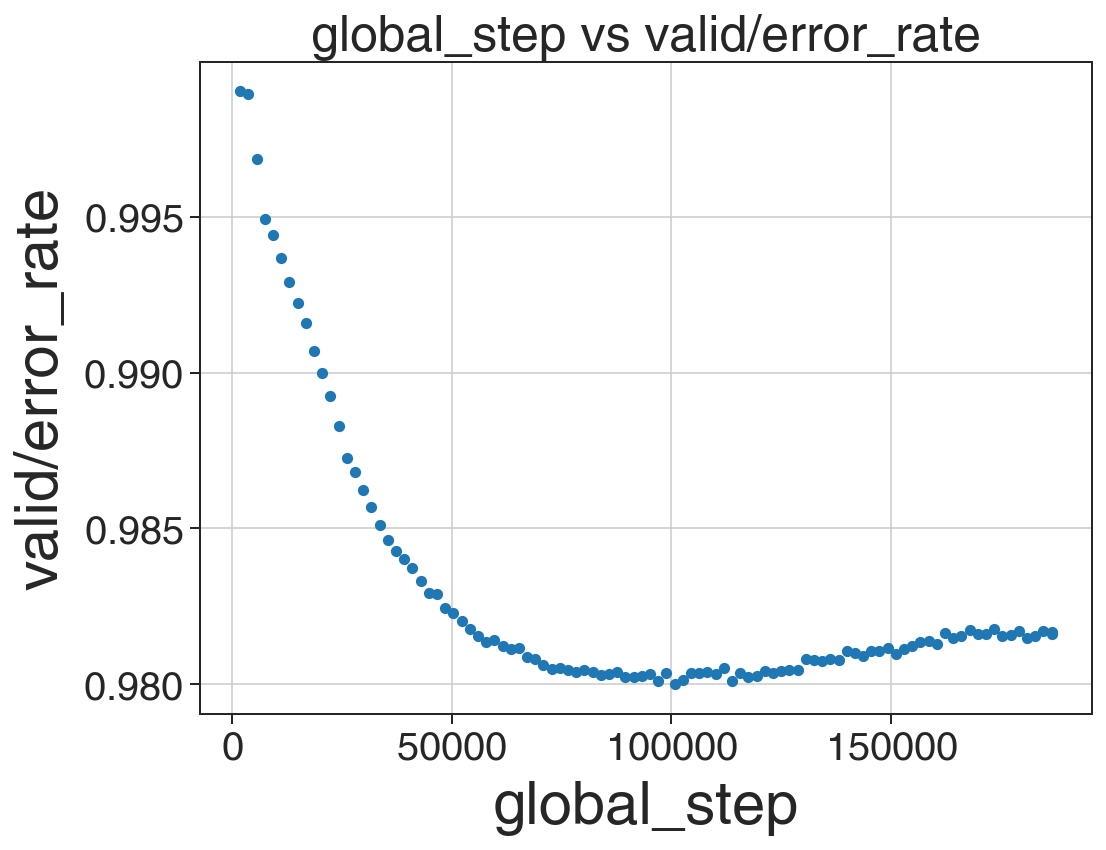

In [25]:
# Plot something
x = 'global_step' #@param
y = 'valid/error_rate' #@param
for _, trial in experiment_df.iterrows():
  plt.scatter(trial[x], trial[y])
  plt.title(f'{x} vs {y}')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.show()
  break

# Summarize

In [9]:
#@title Add columns to 'summarize' trial runs

# Example: Add the best metric value for each trial
best = np.min if df_utils.is_minimized(metric_name) else np.max
experiment_df[f'best_{metric_name}']  = experiment_df[metric_name].apply(lambda r: best(r))
experiment_df = experiment_df.sort_values(by=f'best_{metric_name}', ascending=False)  # optionally sort if you want to inspect the data frame

In [14]:
hparam_cols = get_hparams(experiment_df)
swept_cols = []

for c in hparam_cols:
  if len(experiment_df[c].unique()) > 1:
    swept_cols.append(c)

In [15]:
swept_cols

['hps.lr_hparams.base_lr', 'hps.opt_hparams.c_mom', 'hps.opt_hparams.kappa']

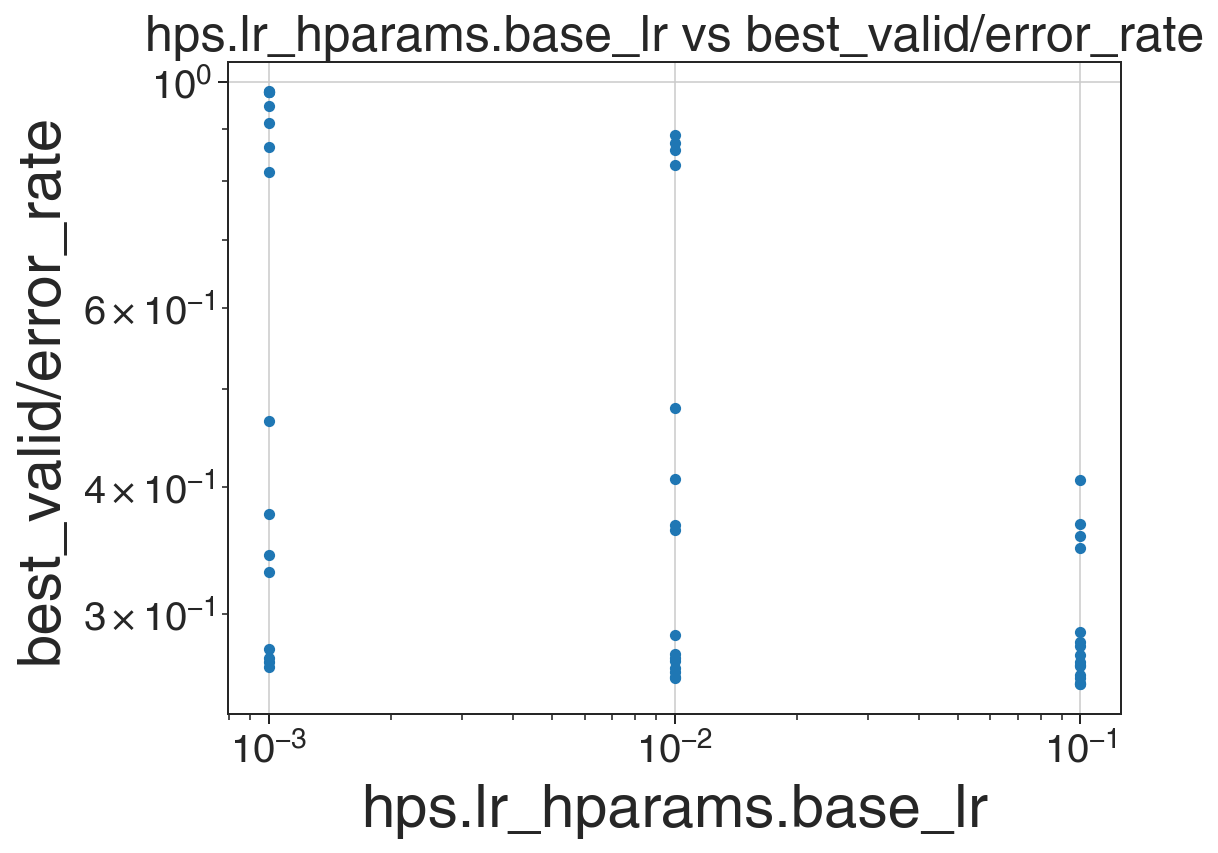

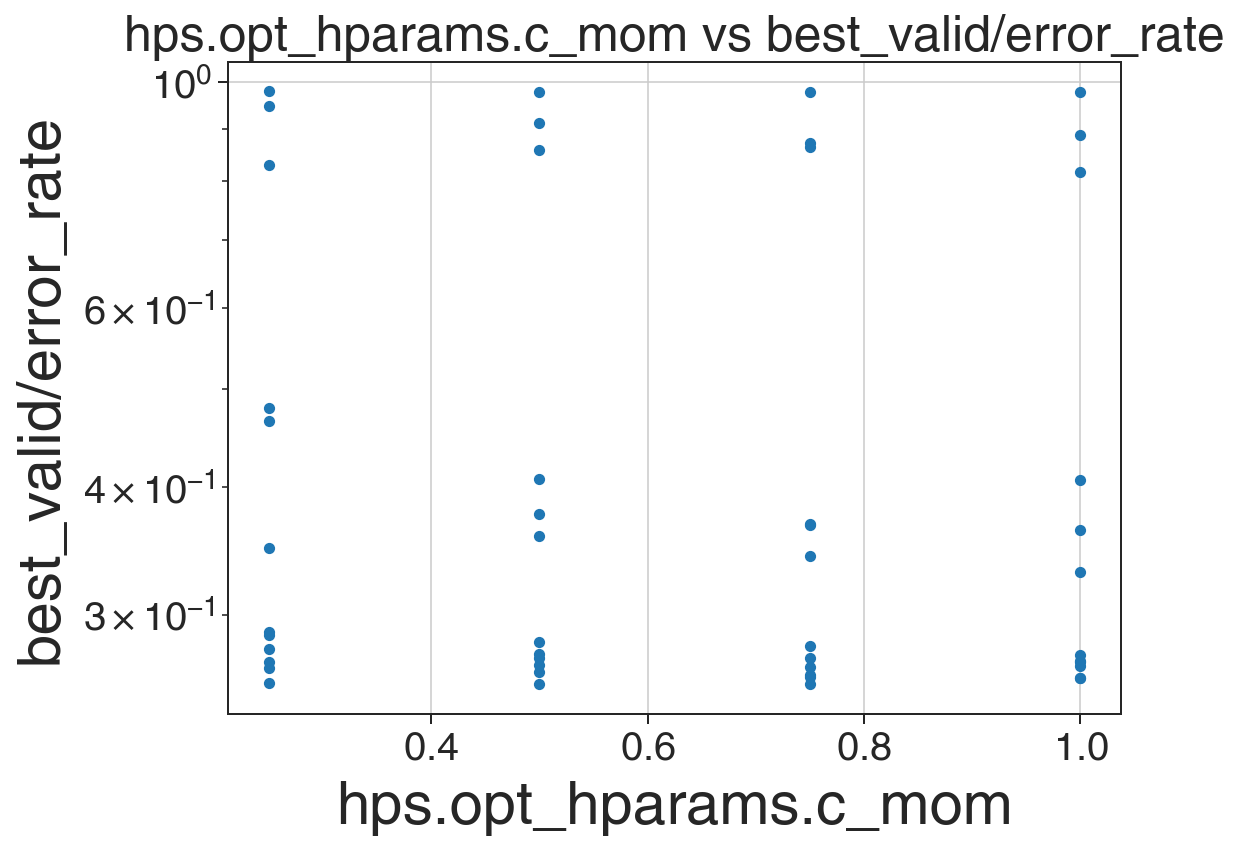

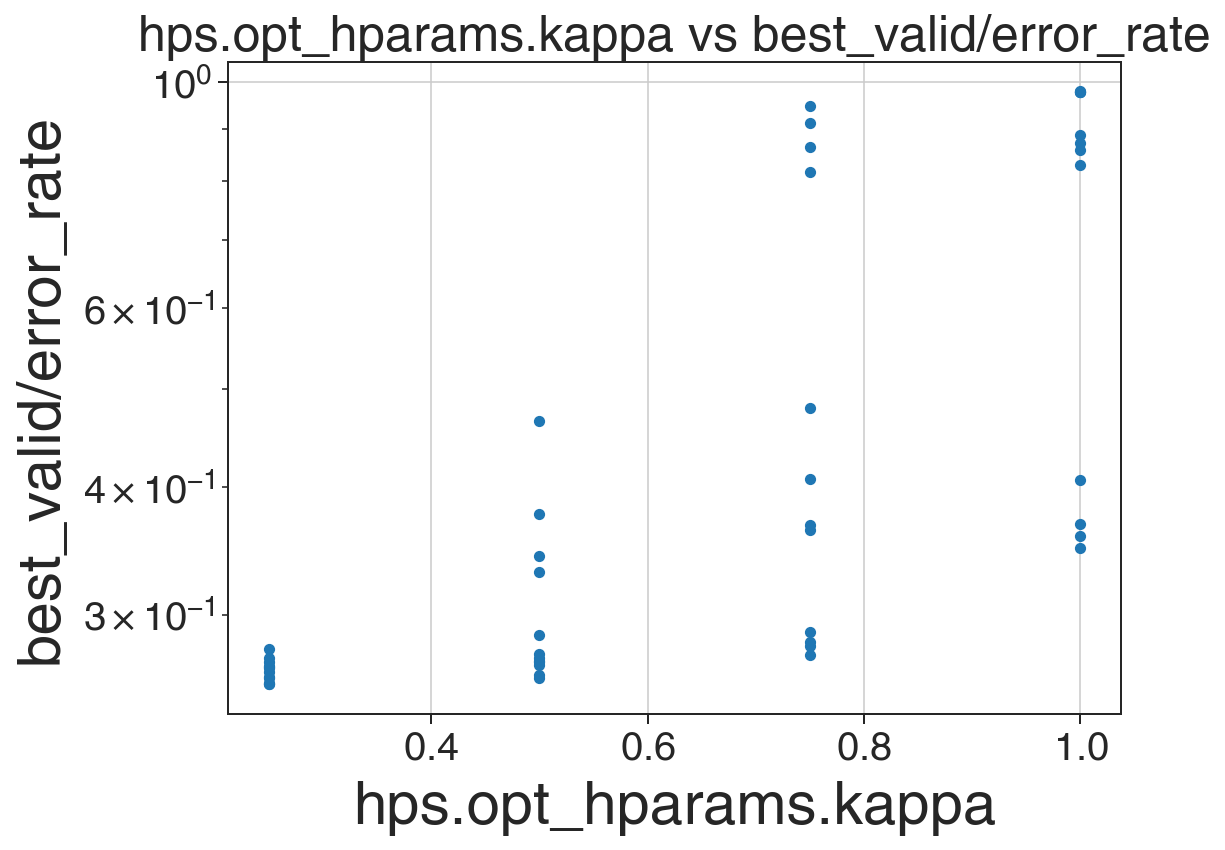

In [16]:
#@title Plot some summary metric as a function of swept hyperparameters

for c in swept_cols:
  plt.scatter(experiment_df[c], experiment_df[f'best_{metric_name}'])
  if 'base_lr' in c:
    plt.xscale('log')
  plt.yscale('log')
  plt.ylabel(f'best_{metric_name}')
  plt.xlabel(c)
  plt.title(f'{c} vs best_{metric_name}')
  plt.show()
  print(' ')


In [19]:
#@title Group by kappa
group_col = 'hps.opt_hparams.kappa'

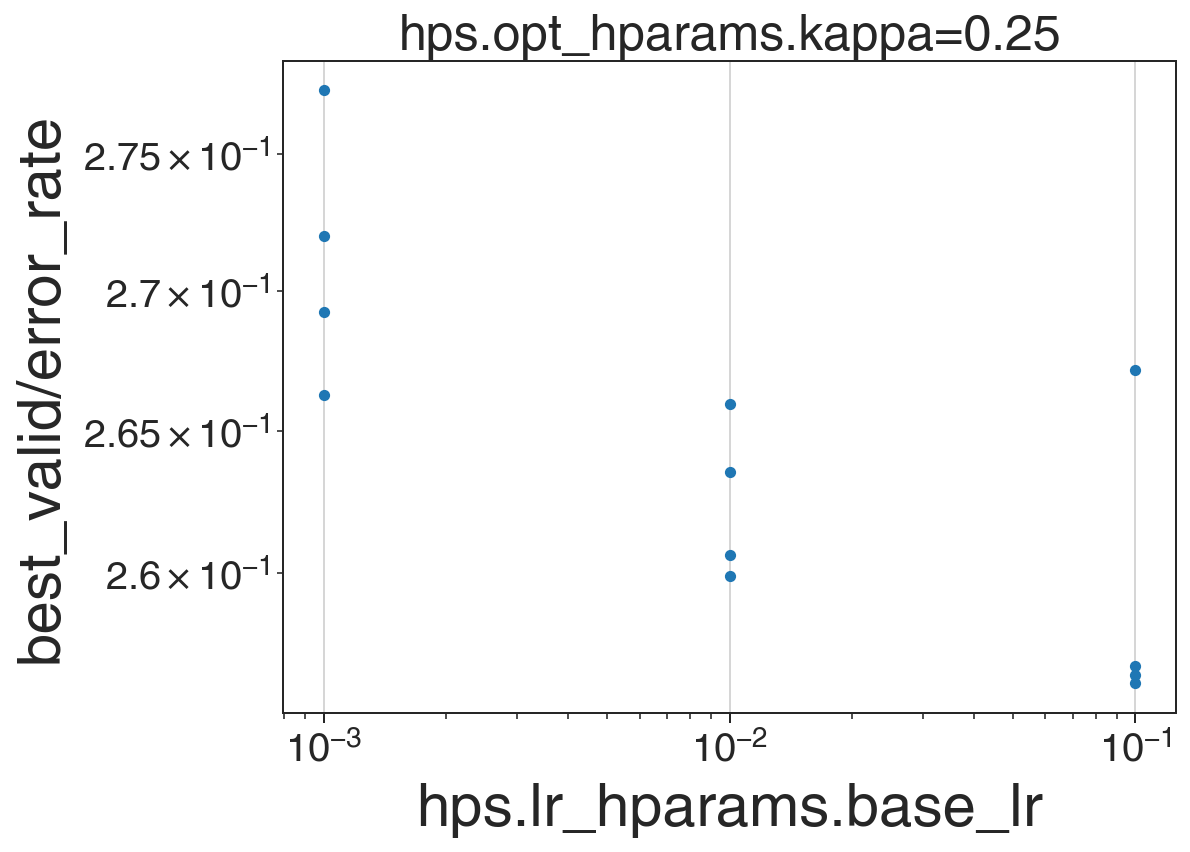

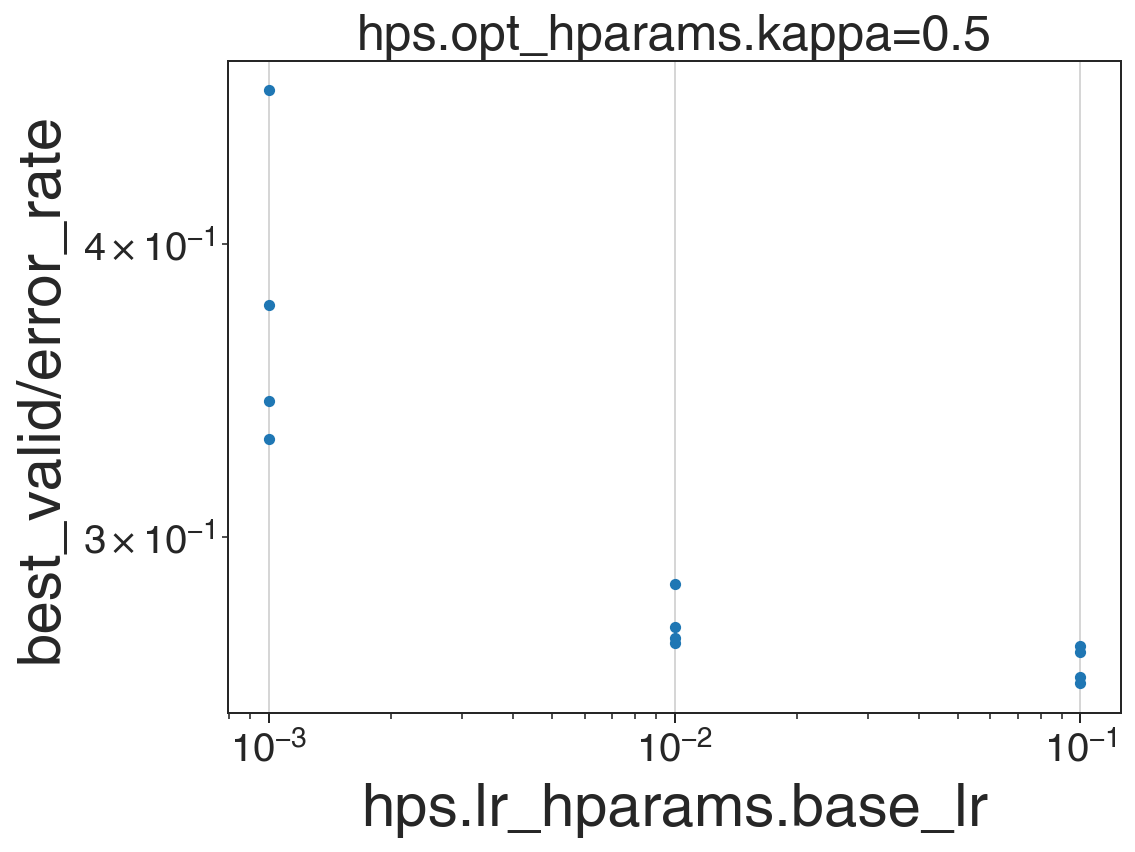

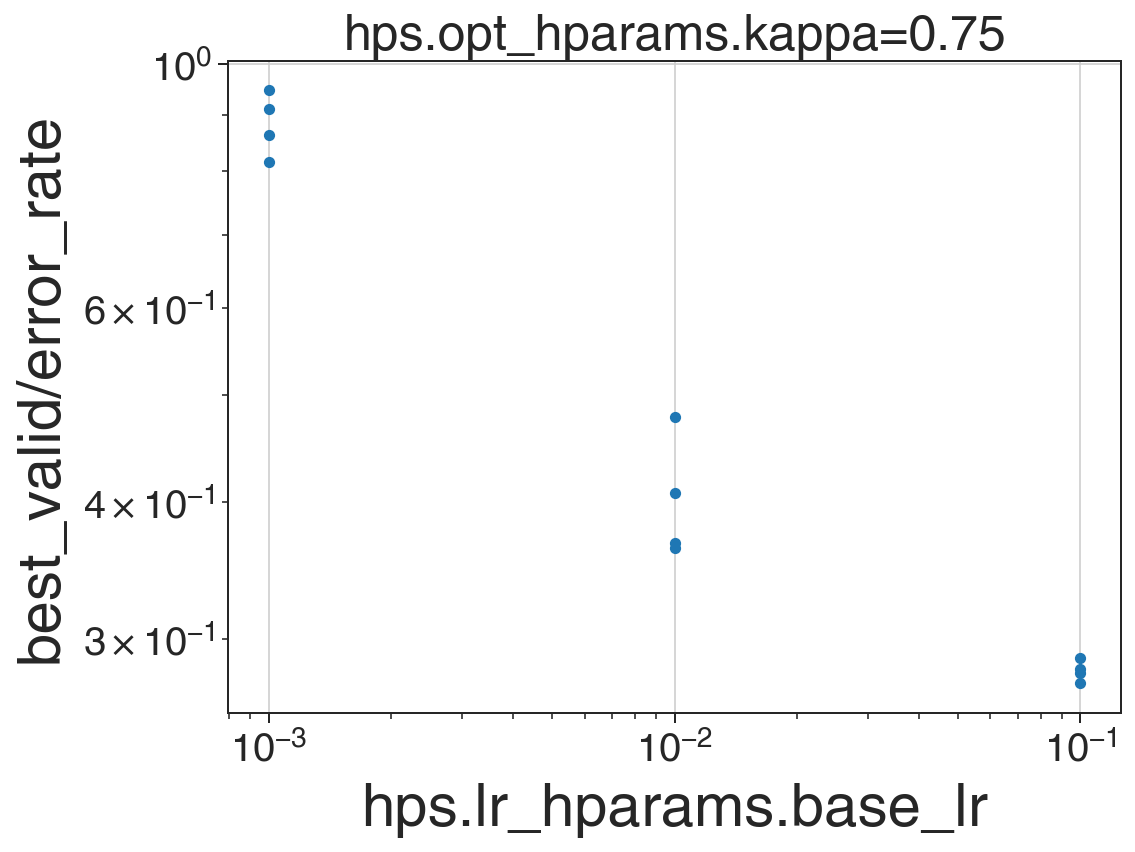

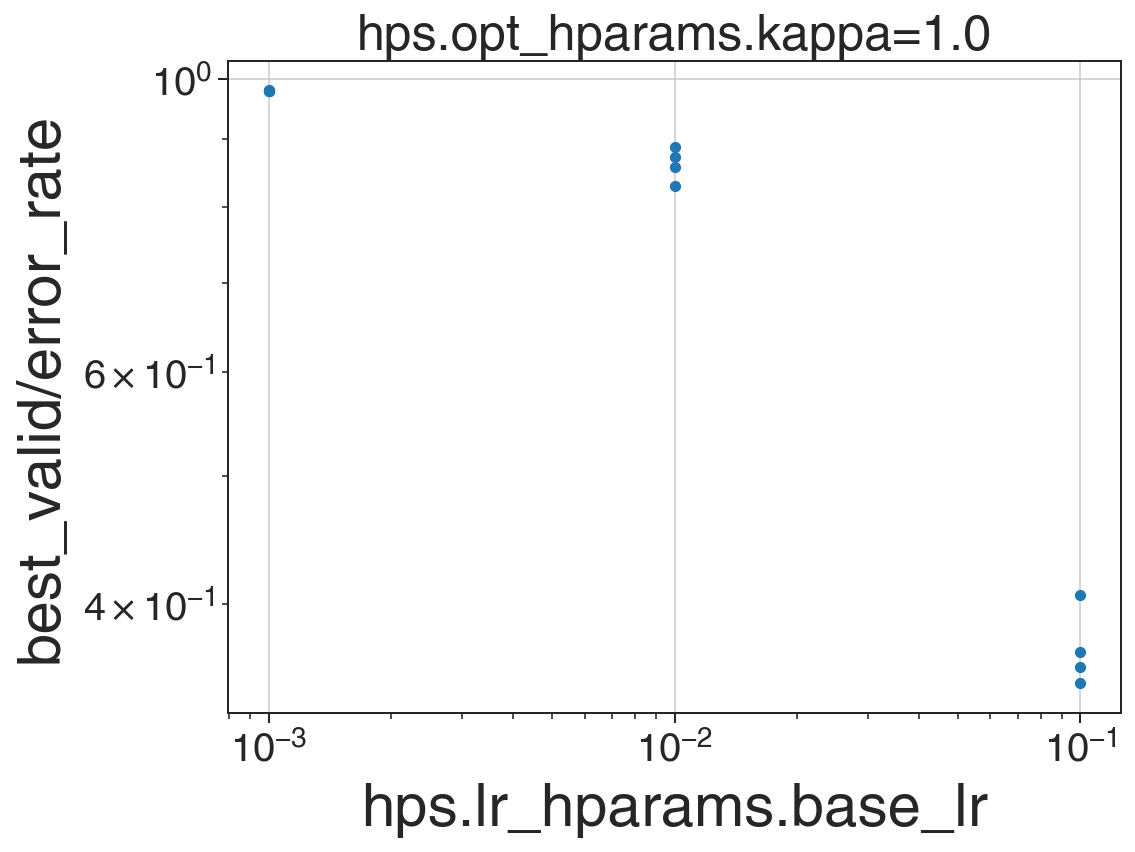

In [20]:
hparam_col = 'hps.lr_hparams.base_lr'

for group_value, df in experiment_df.groupby(group_col):
  plt.scatter(df[hparam_col], df[f'best_{metric_name}'])
  plt.xscale('log')
  plt.yscale('log')
  plt.ylabel(f'best_{metric_name}')
  plt.xlabel(f'{hparam_col}')
  plt.title(f'{group_col}={group_value}')
  plt.show()
  print(' ')

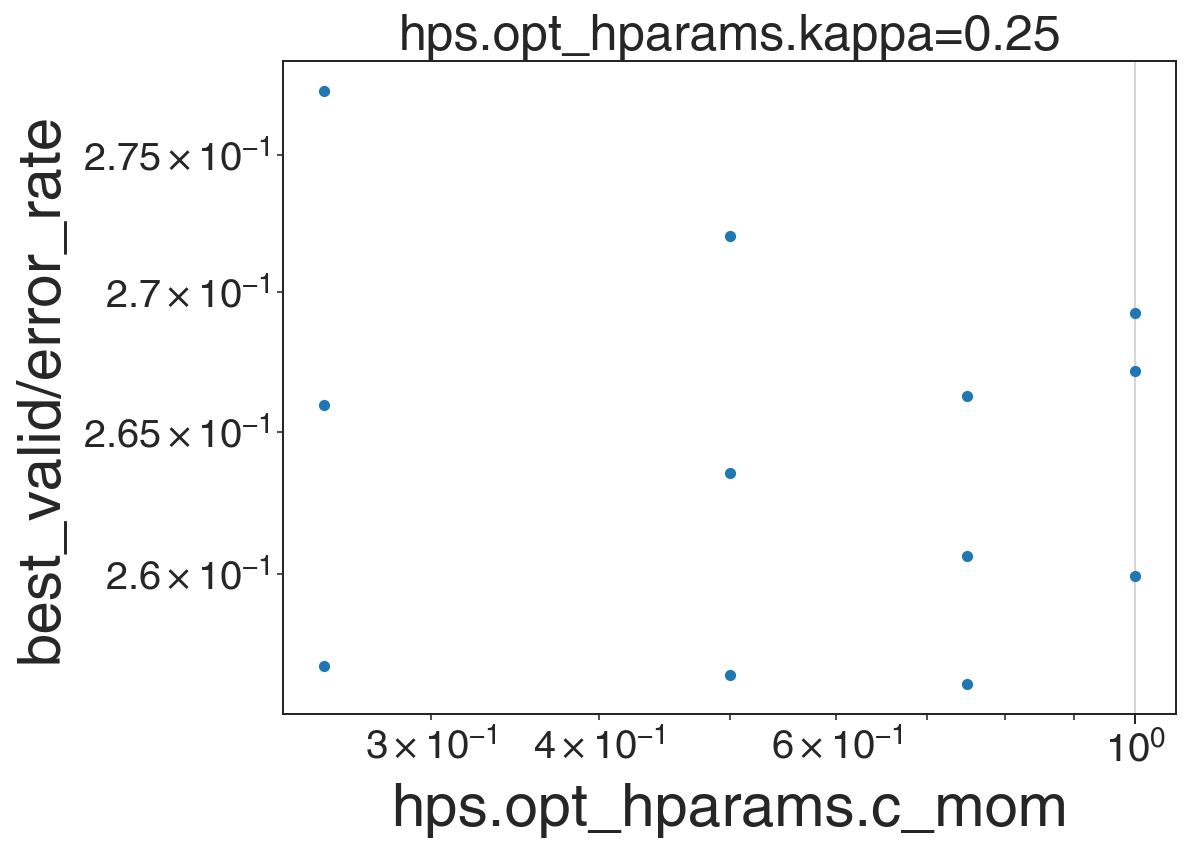

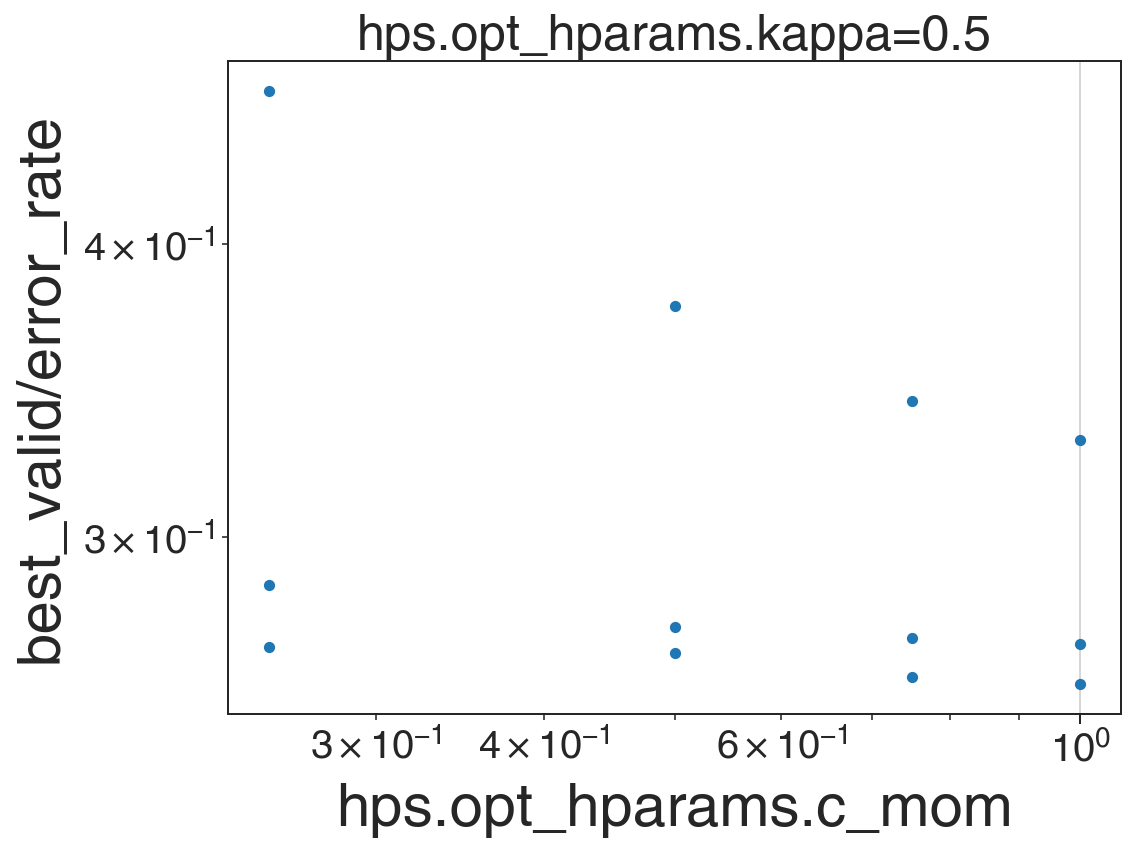

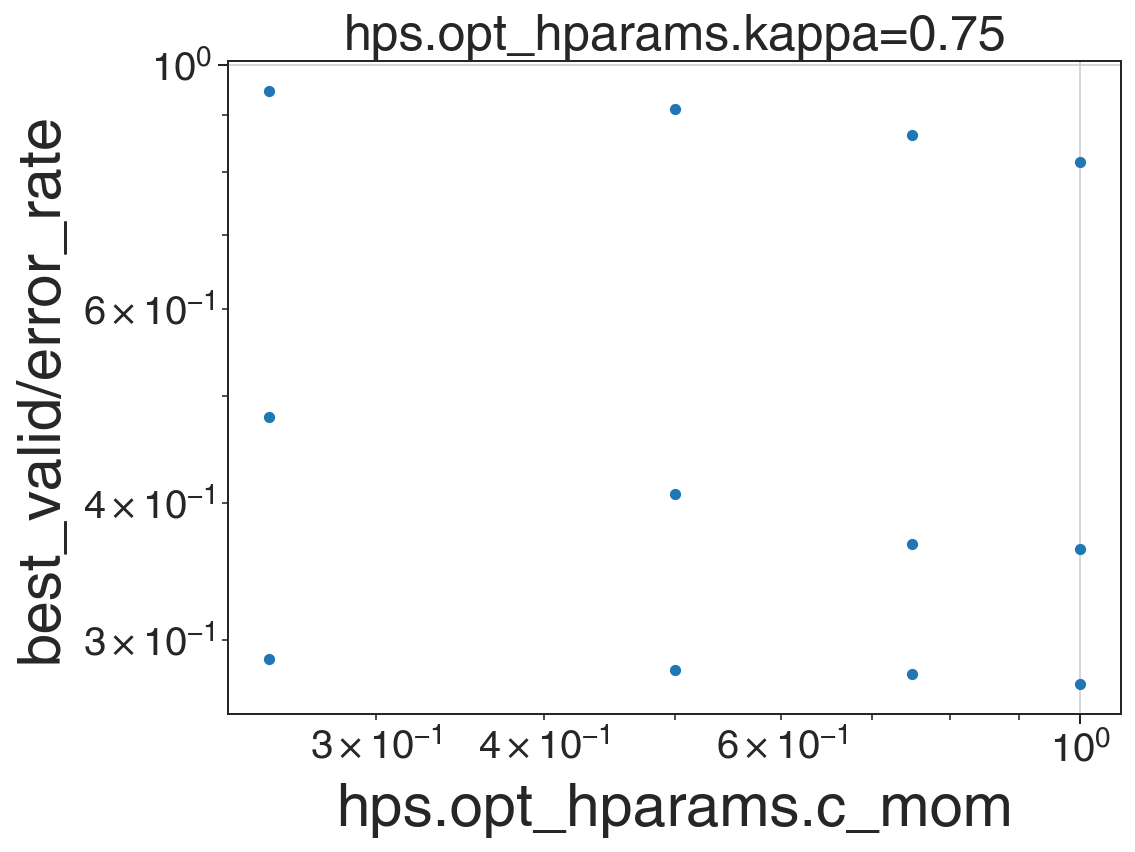

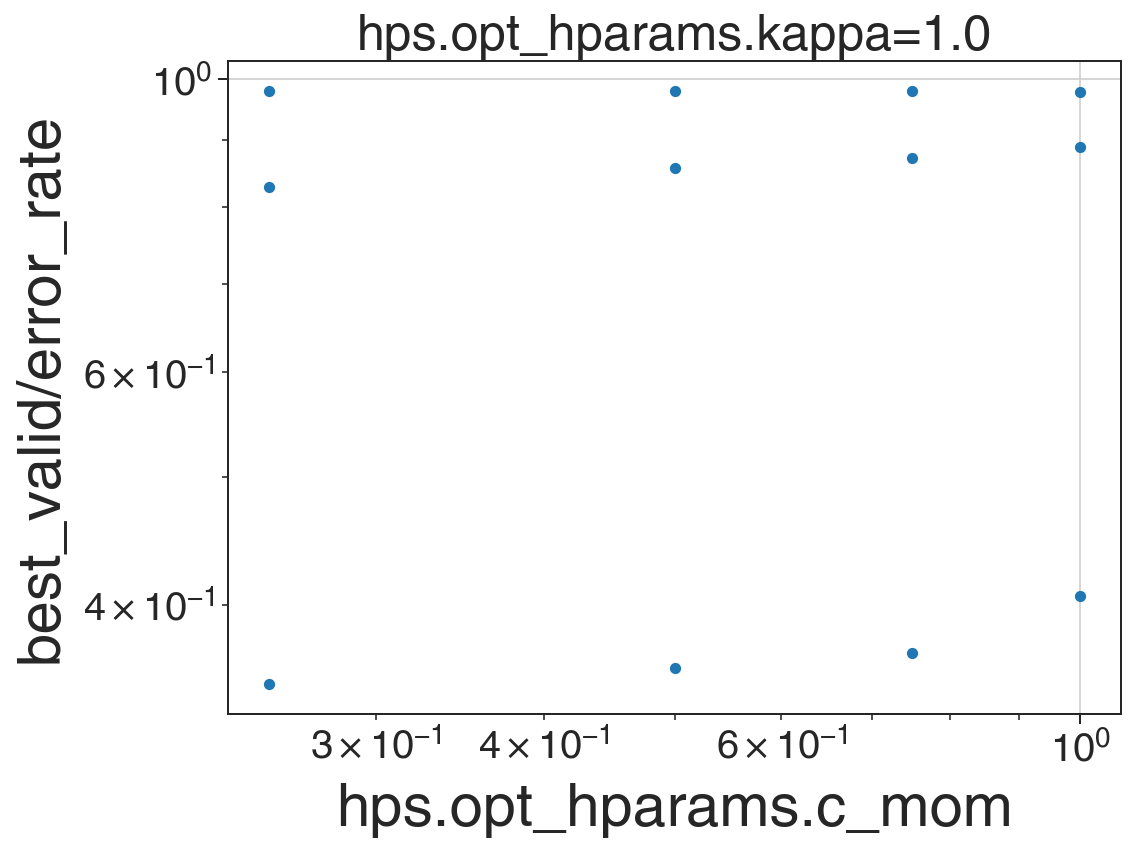

In [23]:
hparam_col = 'hps.opt_hparams.c_mom'

for group_value, df in experiment_df.groupby(group_col):
  plt.scatter(df[hparam_col], df[f'best_{metric_name}'])
  plt.xscale('log')
  plt.yscale('log')
  plt.ylabel(f'best_{metric_name}')
  plt.xlabel(f'{hparam_col}')
  plt.title(f'{group_col}={group_value}')
  plt.show()
  print(' ')

### Learning curves for a fixed value of $\kappa$

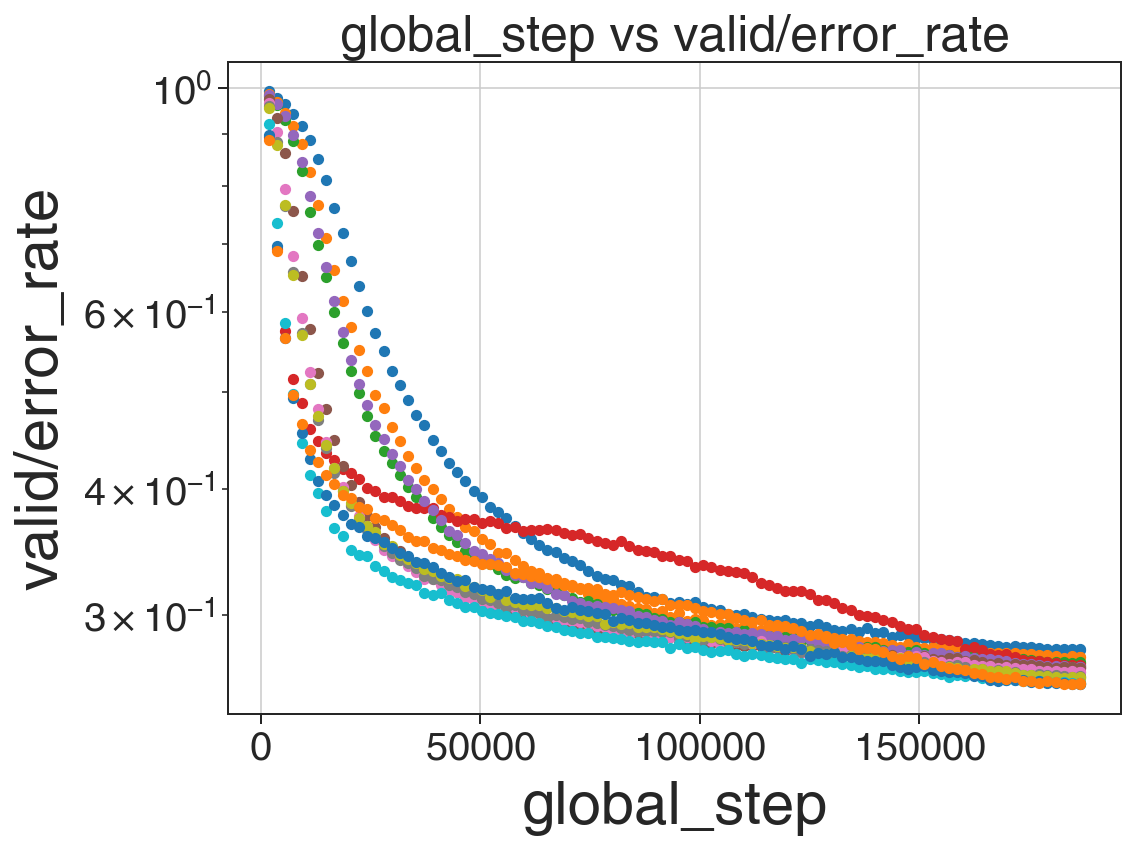

In [27]:
x = 'global_step' #@param
y = 'valid/error_rate' #@param

hparam_col = 'hps.opt_hparams.kappa'
hparam_val = 0.25

for group_value, df in experiment_df.groupby(group_col):
  if group_value != hparam_val:
    continue
  plt.figure()
  for _, trial in df.iterrows():
    plt.scatter(trial[x], trial[y])
  plt.title(f'{x} vs {y}')
  plt.xlabel(x)
  plt.ylabel(y)
  plt.yscale('log')

# Use a Colab visualization cell to visualize the dataframe

In [24]:
#@title Sanitize df for NaNs and infs

experiment_df_sanitized = experiment_df[np.isfinite(experiment_df[f'best_{metric_name}'])]

In [25]:
# dataframe: experiment_df_sanitized
# uuid: D8C5F5E2-2C5A-44C1-9E5E-A1B9D16BF50A
# output_variable:

import google3.research.colab.lib._interactive_viz as _vizcell
_vizcell.explore_dataframe(df_or_df_name='experiment_df_sanitized', uuid='D8C5F5E2-2C5A-44C1-9E5E-A1B9D16BF50A')

<IPython.core.display.Javascript object>